In [1]:
import cv2
import numpy as np
import math
import os
import random

In [2]:
#Main variables
SCALAR_BLACK = (0.0, 0.0, 0.0)
SCALAR_WHITE = (255.0, 255.0, 255.0)
SCALAR_YELLOW = (0.0, 255.0, 255.0)
SCALAR_GREEN = (0.0, 255.0, 0.0)
SCALAR_RED = (0.0, 0.0, 255.0)

In [3]:
#Preprocessing

In [4]:
GAUSSIAN_SMOOTH_FILTER_SIZE = (5, 5)
ADAPTIVE_THRESH_BLOCK_SIZE = 19
ADAPTIVE_THRESH_WEIGHT = 9

In [5]:
def preprocess(imgOriginal):
    imgGrayscale = extractValue(imgOriginal)
    imgMaxContrastGrayscale = maximizeContrast(imgGrayscale)
    height, width = imgGrayscale.shape
    imgBlurred = np.zeros((height, width, 1), np.uint8)
    imgBlurred = cv2.GaussianBlur(imgMaxContrastGrayscale, GAUSSIAN_SMOOTH_FILTER_SIZE, 0)
    imgThresh = cv2.adaptiveThreshold(imgBlurred, 255.0, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, ADAPTIVE_THRESH_BLOCK_SIZE, ADAPTIVE_THRESH_WEIGHT)

    return imgGrayscale, imgThresh

In [6]:
def extractValue(imgOriginal):
    height, width, numChannels = imgOriginal.shape
    imgHSV = np.zeros((height, width, 3), np.uint8)
    imgHSV = cv2.cvtColor(imgOriginal, cv2.COLOR_BGR2HSV)
    imgHue, imgSaturation, imgValue = cv2.split(imgHSV)

    return imgValue

In [7]:
def maximizeContrast(imgGrayscale):

    height, width = imgGrayscale.shape
    imgTopHat = np.zeros((height, width, 1), np.uint8)
    imgBlackHat = np.zeros((height, width, 1), np.uint8)
    structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

    imgTopHat = cv2.morphologyEx(imgGrayscale, cv2.MORPH_TOPHAT, structuringElement)
    imgBlackHat = cv2.morphologyEx(imgGrayscale, cv2.MORPH_BLACKHAT, structuringElement)

    imgGrayscalePlusTopHat = cv2.add(imgGrayscale, imgTopHat)
    imgGrayscalePlusTopHatMinusBlackHat = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

    return imgGrayscalePlusTopHatMinusBlackHat

In [8]:
#Possible Plate

In [9]:
class PossiblePlate:
    def __init__(self):
        self.imgPlate = None
        self.imgGrayscale = None
        self.imgThresh = None
        self.rrLocationOfPlateInScene = None
        self.strChars = ""

In [10]:
#Possible Character

In [11]:
class PossibleChar:
    def __init__(self, _contour):
        self.contour = _contour

        self.boundingRect = cv2.boundingRect(self.contour)

        [intX, intY, intWidth, intHeight] = self.boundingRect

        self.intBoundingRectX = intX
        self.intBoundingRectY = intY
        self.intBoundingRectWidth = intWidth
        self.intBoundingRectHeight = intHeight

        self.intBoundingRectArea = self.intBoundingRectWidth * self.intBoundingRectHeight

        self.intCenterX = (self.intBoundingRectX + self.intBoundingRectX + self.intBoundingRectWidth) / 2
        self.intCenterY = (self.intBoundingRectY + self.intBoundingRectY + self.intBoundingRectHeight) / 2

        self.fltDiagonalSize = math.sqrt((self.intBoundingRectWidth ** 2) + (self.intBoundingRectHeight ** 2))

        self.fltAspectRatio = float(self.intBoundingRectWidth) / float(self.intBoundingRectHeight)

In [12]:
#Detect Characters

In [13]:
kNearest = cv2.ml.KNearest_create()

MIN_PIXEL_WIDTH = 2
MIN_PIXEL_HEIGHT = 8
MIN_ASPECT_RATIO = 0.25
MAX_ASPECT_RATIO = 1.0
MIN_PIXEL_AREA = 80
MIN_DIAG_SIZE_MULTIPLE_AWAY = 0.3
MAX_DIAG_SIZE_MULTIPLE_AWAY = 5.0
MAX_CHANGE_IN_AREA = 0.5
MAX_CHANGE_IN_WIDTH = 0.8
MAX_CHANGE_IN_HEIGHT = 0.2
MAX_ANGLE_BETWEEN_CHARS = 12.0
MIN_NUMBER_OF_MATCHING_CHARS = 3

RESIZED_CHAR_IMAGE_WIDTH = 20
RESIZED_CHAR_IMAGE_HEIGHT = 30

MIN_CONTOUR_AREA = 100

def loadKNNDataAndTrainKNN():
    allContoursWithData = []                
    validContoursWithData = []              

    try:
        npaClassifications = np.loadtxt("classifications.txt", np.float32)                  
    except:                                                                                 
        print("error, unable to open classifications.txt, exiting program\n") 
        os.system("pause")
        return False                                                                        

    try:
        npaFlattenedImages = np.loadtxt("flattened_images.txt", np.float32)                 
    except:                                                                                 
        print("error, unable to open flattened_images.txt, exiting program\n")  
        os.system("pause")
        return False                                                                        

    # train KNN object, K = 1
    npaClassifications = npaClassifications.reshape((npaClassifications.size, 1))
    kNearest.setDefaultK(1)                                                             
    kNearest.train(npaFlattenedImages, cv2.ml.ROW_SAMPLE, npaClassifications)           

    return True                             

def detectCharsInPlates(listOfPossiblePlates):
    intPlateCounter = 0
    imgContours = None
    contours = []

    if len(listOfPossiblePlates) == 0:          
        return listOfPossiblePlates             
    

    for possiblePlate in listOfPossiblePlates:          

        possiblePlate.imgGrayscale, possiblePlate.imgThresh = preprocess(possiblePlate.imgPlate)     
        possiblePlate.imgThresh = cv2.resize(possiblePlate.imgThresh, (0, 0), fx = 1.6, fy = 1.6)
        thresholdValue, possiblePlate.imgThresh = cv2.threshold(possiblePlate.imgThresh, 0.0, 255.0, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        listOfPossibleCharsInPlate = findPossibleCharsInPlate(possiblePlate.imgGrayscale, possiblePlate.imgThresh)
        listOfListsOfMatchingCharsInPlate = findListOfListsOfMatchingChars(listOfPossibleCharsInPlate)

        if (len(listOfListsOfMatchingCharsInPlate) == 0):

            possiblePlate.strChars = ""
            continue

        for i in range(0, len(listOfListsOfMatchingCharsInPlate)):                             
            listOfListsOfMatchingCharsInPlate[i].sort(key = lambda matchingChar: matchingChar.intCenterX)       
            listOfListsOfMatchingCharsInPlate[i] = removeInnerOverlappingChars(listOfListsOfMatchingCharsInPlate[i])              
        intLenOfLongestListOfChars = 0
        intIndexOfLongestListOfChars = 0

                
        for i in range(0, len(listOfListsOfMatchingCharsInPlate)):
            if len(listOfListsOfMatchingCharsInPlate[i]) > intLenOfLongestListOfChars:
                intLenOfLongestListOfChars = len(listOfListsOfMatchingCharsInPlate[i])
                intIndexOfLongestListOfChars = i
            
        longestListOfMatchingCharsInPlate = listOfListsOfMatchingCharsInPlate[intIndexOfLongestListOfChars]
        possiblePlate.strChars = recognizeCharsInPlate(possiblePlate.imgThresh, longestListOfMatchingCharsInPlate)

    return listOfPossiblePlates

def findPossibleCharsInPlate(imgGrayscale, imgThresh):
    listOfPossibleChars = []                        
    contours = []
    imgThreshCopy = imgThresh.copy()
    contours, npaHierarchy = cv2.findContours(imgThreshCopy, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:                        
        possibleChar = PossibleChar(contour)

        if checkIfPossibleChar(possibleChar):              
            listOfPossibleChars.append(possibleChar)       

    return listOfPossibleChars

def checkIfPossibleChar(possibleChar):
            
    if (possibleChar.intBoundingRectArea > MIN_PIXEL_AREA and
        possibleChar.intBoundingRectWidth > MIN_PIXEL_WIDTH and possibleChar.intBoundingRectHeight > MIN_PIXEL_HEIGHT and
        MIN_ASPECT_RATIO < possibleChar.fltAspectRatio and possibleChar.fltAspectRatio < MAX_ASPECT_RATIO):
        return True
    else:
        return False
    # end if
# end function

###################################################################################################
def findListOfListsOfMatchingChars(listOfPossibleChars):
            # with this function, we start off with all the possible chars in one big list
            # the purpose of this function is to re-arrange the one big list of chars into a list of lists of matching chars,
            # note that chars that are not found to be in a group of matches do not need to be considered further
    listOfListsOfMatchingChars = []                  # this will be the return value

    for possibleChar in listOfPossibleChars:                        # for each possible char in the one big list of chars
        listOfMatchingChars = findListOfMatchingChars(possibleChar, listOfPossibleChars)        # find all chars in the big list that match the current char

        listOfMatchingChars.append(possibleChar)                # also add the current char to current possible list of matching chars

        if len(listOfMatchingChars) < MIN_NUMBER_OF_MATCHING_CHARS:     # if current possible list of matching chars is not long enough to constitute a possible plate
            continue                            # jump back to the top of the for loop and try again with next char, note that it's not necessary
                                                # to save the list in any way since it did not have enough chars to be a possible plate
        # end if

                                                # if we get here, the current list passed test as a "group" or "cluster" of matching chars
        listOfListsOfMatchingChars.append(listOfMatchingChars)      # so add to our list of lists of matching chars

        listOfPossibleCharsWithCurrentMatchesRemoved = []

                                                # remove the current list of matching chars from the big list so we don't use those same chars twice,
                                                # make sure to make a new big list for this since we don't want to change the original big list
        listOfPossibleCharsWithCurrentMatchesRemoved = list(set(listOfPossibleChars) - set(listOfMatchingChars))

        recursiveListOfListsOfMatchingChars = findListOfListsOfMatchingChars(listOfPossibleCharsWithCurrentMatchesRemoved)      # recursive call

        for recursiveListOfMatchingChars in recursiveListOfListsOfMatchingChars:        # for each list of matching chars found by recursive call
            listOfListsOfMatchingChars.append(recursiveListOfMatchingChars)             # add to our original list of lists of matching chars
        # end for

        break       # exit for

    # end for

    return listOfListsOfMatchingChars
# end function

###################################################################################################
def findListOfMatchingChars(possibleChar, listOfChars):
            # the purpose of this function is, given a possible char and a big list of possible chars,
            # find all chars in the big list that are a match for the single possible char, and return those matching chars as a list
    listOfMatchingChars = []                # this will be the return value

    for possibleMatchingChar in listOfChars:                # for each char in big list
        if possibleMatchingChar == possibleChar:    # if the char we attempting to find matches for is the exact same char as the char in the big list we are currently checking
                                                    # then we should not include it in the list of matches b/c that would end up double including the current char
            continue                                # so do not add to list of matches and jump back to top of for loop
        # end if
                    # compute stuff to see if chars are a match
        fltDistanceBetweenChars = distanceBetweenChars(possibleChar, possibleMatchingChar)

        fltAngleBetweenChars = angleBetweenChars(possibleChar, possibleMatchingChar)

        fltChangeInArea = float(abs(possibleMatchingChar.intBoundingRectArea - possibleChar.intBoundingRectArea)) / float(possibleChar.intBoundingRectArea)

        fltChangeInWidth = float(abs(possibleMatchingChar.intBoundingRectWidth - possibleChar.intBoundingRectWidth)) / float(possibleChar.intBoundingRectWidth)
        fltChangeInHeight = float(abs(possibleMatchingChar.intBoundingRectHeight - possibleChar.intBoundingRectHeight)) / float(possibleChar.intBoundingRectHeight)

                # check if chars match
        if (fltDistanceBetweenChars < (possibleChar.fltDiagonalSize * MAX_DIAG_SIZE_MULTIPLE_AWAY) and
            fltAngleBetweenChars < MAX_ANGLE_BETWEEN_CHARS and
            fltChangeInArea < MAX_CHANGE_IN_AREA and
            fltChangeInWidth < MAX_CHANGE_IN_WIDTH and
            fltChangeInHeight < MAX_CHANGE_IN_HEIGHT):

            listOfMatchingChars.append(possibleMatchingChar)        # if the chars are a match, add the current char to list of matching chars
        # end if
    # end for

    return listOfMatchingChars                  # return result
# end function

###################################################################################################
# use Pythagorean theorem to calculate distance between two chars
def distanceBetweenChars(firstChar, secondChar):
    intX = abs(firstChar.intCenterX - secondChar.intCenterX)
    intY = abs(firstChar.intCenterY - secondChar.intCenterY)

    return math.sqrt((intX ** 2) + (intY ** 2))
# end function

###################################################################################################
# use basic trigonometry (SOH CAH TOA) to calculate angle between chars
def angleBetweenChars(firstChar, secondChar):
    fltAdj = float(abs(firstChar.intCenterX - secondChar.intCenterX))
    fltOpp = float(abs(firstChar.intCenterY - secondChar.intCenterY))

    if fltAdj != 0.0:                           # check to make sure we do not divide by zero if the center X positions are equal, float division by zero will cause a crash in Python
        fltAngleInRad = math.atan(fltOpp / fltAdj)      # if adjacent is not zero, calculate angle
    else:
        fltAngleInRad = 1.5708                          # if adjacent is zero, use this as the angle, this is to be consistent with the C++ version of this program
    # end if

    fltAngleInDeg = fltAngleInRad * (180.0 / math.pi)       # calculate angle in degrees

    return fltAngleInDeg
# end function

###################################################################################################
# if we have two chars overlapping or to close to each other to possibly be separate chars, remove the inner (smaller) char,
# this is to prevent including the same char twice if two contours are found for the same char,
# for example for the letter 'O' both the inner ring and the outer ring may be found as contours, but we should only include the char once
def removeInnerOverlappingChars(listOfMatchingChars):
    listOfMatchingCharsWithInnerCharRemoved = list(listOfMatchingChars)                # this will be the return value

    for currentChar in listOfMatchingChars:
        for otherChar in listOfMatchingChars:
            if currentChar != otherChar:        # if current char and other char are not the same char . . .
                                                                            # if current char and other char have center points at almost the same location . . .
                if distanceBetweenChars(currentChar, otherChar) < (currentChar.fltDiagonalSize * MIN_DIAG_SIZE_MULTIPLE_AWAY):
                                # if we get in here we have found overlapping chars
                                # next we identify which char is smaller, then if that char was not already removed on a previous pass, remove it
                    if currentChar.intBoundingRectArea < otherChar.intBoundingRectArea:         # if current char is smaller than other char
                        if currentChar in listOfMatchingCharsWithInnerCharRemoved:              # if current char was not already removed on a previous pass . . .
                            listOfMatchingCharsWithInnerCharRemoved.remove(currentChar)         # then remove current char
                        # end if
                    else:                                                                       # else if other char is smaller than current char
                        if otherChar in listOfMatchingCharsWithInnerCharRemoved:                # if other char was not already removed on a previous pass . . .
                            listOfMatchingCharsWithInnerCharRemoved.remove(otherChar)           # then remove other char
                        # end if
                    # end if
                # end if
            # end if
        # end for
    # end for

    return listOfMatchingCharsWithInnerCharRemoved
# end function

###################################################################################################
# this is where we apply the actual char recognition
def recognizeCharsInPlate(imgThresh, listOfMatchingChars):
    strChars = ""               # this will be the return value, the chars in the lic plate

    height, width = imgThresh.shape

    imgThreshColor = np.zeros((height, width, 3), np.uint8)

    listOfMatchingChars.sort(key = lambda matchingChar: matchingChar.intCenterX)        # sort chars from left to right

    cv2.cvtColor(imgThresh, cv2.COLOR_GRAY2BGR, imgThreshColor)                     # make color version of threshold image so we can draw contours in color on it

    for currentChar in listOfMatchingChars:                                         # for each char in plate
        pt1 = (currentChar.intBoundingRectX, currentChar.intBoundingRectY)
        pt2 = ((currentChar.intBoundingRectX + currentChar.intBoundingRectWidth), (currentChar.intBoundingRectY + currentChar.intBoundingRectHeight))

        cv2.rectangle(imgThreshColor, pt1, pt2, SCALAR_GREEN, 2)           # draw green box around the char

                # crop char out of threshold image
        imgROI = imgThresh[currentChar.intBoundingRectY : currentChar.intBoundingRectY + currentChar.intBoundingRectHeight,
                           currentChar.intBoundingRectX : currentChar.intBoundingRectX + currentChar.intBoundingRectWidth]

        imgROIResized = cv2.resize(imgROI, (RESIZED_CHAR_IMAGE_WIDTH, RESIZED_CHAR_IMAGE_HEIGHT))           # resize image, this is necessary for char recognition

        npaROIResized = imgROIResized.reshape((1, RESIZED_CHAR_IMAGE_WIDTH * RESIZED_CHAR_IMAGE_HEIGHT))        # flatten image into 1d numpy array

        npaROIResized = np.float32(npaROIResized)               # convert from 1d numpy array of ints to 1d numpy array of floats

        retval, npaResults, neigh_resp, dists = kNearest.findNearest(npaROIResized, k = 1)              # finally we can call findNearest !!!

        strCurrentChar = str(chr(int(npaResults[0][0])))            # get character from results

        strChars = strChars + strCurrentChar                        # append current char to full string

    # end for

    return strChars
# end function


In [14]:
#Detect Plates

In [15]:
# module level variables ##########################################################################
PLATE_WIDTH_PADDING_FACTOR = 1.3
PLATE_HEIGHT_PADDING_FACTOR = 1.5

###################################################################################################
def detectPlatesInScene(imgOriginalScene):
    listOfPossiblePlates = []                   # this will be the return value

    height, width, numChannels = imgOriginalScene.shape

    imgGrayscaleScene = np.zeros((height, width, 1), np.uint8)
    imgThreshScene = np.zeros((height, width, 1), np.uint8)
    imgContours = np.zeros((height, width, 3), np.uint8)

    cv2.destroyAllWindows()

    

    imgGrayscaleScene, imgThreshScene = preprocess(imgOriginalScene)         # preprocess to get grayscale and threshold images


            # find all possible chars in the scene,
            # this function first finds all contours, then only includes contours that could be chars (without comparison to other chars yet)
    listOfPossibleCharsInScene = findPossibleCharsInScene(imgThreshScene)


            # given a list of all possible chars, find groups of matching chars
            # in the next steps each group of matching chars will attempt to be recognized as a plate
    listOfListsOfMatchingCharsInScene = findListOfListsOfMatchingChars(listOfPossibleCharsInScene)


    for listOfMatchingChars in listOfListsOfMatchingCharsInScene:                   # for each group of matching chars
        possiblePlate = extractPlate(imgOriginalScene, listOfMatchingChars)         # attempt to extract plate

        if possiblePlate.imgPlate is not None:                          # if plate was found
            listOfPossiblePlates.append(possiblePlate)                  # add to list of possible plates
        # end if
    # end for

    #print("\n" + str(len(listOfPossiblePlates)) + " possible plates found")  # 13 with MCLRNF1 image


    return listOfPossiblePlates
# end function





###################################################################################################
def findPossibleCharsInScene(imgThresh):
    listOfPossibleChars = []                # this will be the return value

    intCountOfPossibleChars = 0

    imgThreshCopy = imgThresh.copy()

    contours, npaHierarchy = cv2.findContours(imgThreshCopy, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)   # find all contours

    height, width = imgThresh.shape
    imgContours = np.zeros((height, width, 3), np.uint8)

    for i in range(0, len(contours)):                       # for each contour

        possibleChar = PossibleChar(contours[i])

        if checkIfPossibleChar(possibleChar):                   # if contour is a possible char, note this does not compare to other chars (yet) . . .
            intCountOfPossibleChars = intCountOfPossibleChars + 1           # increment count of possible chars
            listOfPossibleChars.append(possibleChar)                        # and add to list of possible chars
        # end if
    # end for


    return listOfPossibleChars
# end function


###################################################################################################
def extractPlate(imgOriginal, listOfMatchingChars):
    possiblePlate = PossiblePlate()           # this will be the return value

    listOfMatchingChars.sort(key = lambda matchingChar: matchingChar.intCenterX)        # sort chars from left to right based on x position

            # calculate the center point of the plate
    fltPlateCenterX = (listOfMatchingChars[0].intCenterX + listOfMatchingChars[len(listOfMatchingChars) - 1].intCenterX) / 2.0
    fltPlateCenterY = (listOfMatchingChars[0].intCenterY + listOfMatchingChars[len(listOfMatchingChars) - 1].intCenterY) / 2.0

    ptPlateCenter = fltPlateCenterX, fltPlateCenterY

            # calculate plate width and height
    intPlateWidth = int((listOfMatchingChars[len(listOfMatchingChars) - 1].intBoundingRectX + listOfMatchingChars[len(listOfMatchingChars) - 1].intBoundingRectWidth - listOfMatchingChars[0].intBoundingRectX) * PLATE_WIDTH_PADDING_FACTOR)

    intTotalOfCharHeights = 0

    for matchingChar in listOfMatchingChars:
        intTotalOfCharHeights = intTotalOfCharHeights + matchingChar.intBoundingRectHeight
    # end for

    fltAverageCharHeight = intTotalOfCharHeights / len(listOfMatchingChars)

    intPlateHeight = int(fltAverageCharHeight * PLATE_HEIGHT_PADDING_FACTOR)

            # calculate correction angle of plate region
    fltOpposite = listOfMatchingChars[len(listOfMatchingChars) - 1].intCenterY - listOfMatchingChars[0].intCenterY
    fltHypotenuse = distanceBetweenChars(listOfMatchingChars[0], listOfMatchingChars[len(listOfMatchingChars) - 1])
    fltCorrectionAngleInRad = math.asin(fltOpposite / fltHypotenuse)
    fltCorrectionAngleInDeg = fltCorrectionAngleInRad * (180.0 / math.pi)

            # pack plate region center point, width and height, and correction angle into rotated rect member variable of plate
    possiblePlate.rrLocationOfPlateInScene = ( tuple(ptPlateCenter), (intPlateWidth, intPlateHeight), fltCorrectionAngleInDeg )

            # final steps are to perform the actual rotation

            # get the rotation matrix for our calculated correction angle
    rotationMatrix = cv2.getRotationMatrix2D(tuple(ptPlateCenter), fltCorrectionAngleInDeg, 1.0)

    height, width, numChannels = imgOriginal.shape      # unpack original image width and height

    imgRotated = cv2.warpAffine(imgOriginal, rotationMatrix, (width, height))       # rotate the entire image

    imgCropped = cv2.getRectSubPix(imgRotated, (intPlateWidth, intPlateHeight), tuple(ptPlateCenter))

    possiblePlate.imgPlate = imgCropped         # copy the cropped plate image into the applicable member variable of the possible plate

    return possiblePlate
# end function

In [16]:
#Main

In [17]:
def drawRedRectangleAroundPlate(imgOriginalScene, licPlate):

    p2fRectPoints = cv2.boxPoints(licPlate.rrLocationOfPlateInScene)            # get 4 vertices of rotated rect

    cv2.line(imgOriginalScene, tuple(p2fRectPoints[0]), tuple(p2fRectPoints[1]), SCALAR_RED, 2)         # draw 4 red lines
    cv2.line(imgOriginalScene, tuple(p2fRectPoints[1]), tuple(p2fRectPoints[2]), SCALAR_RED, 2)
    cv2.line(imgOriginalScene, tuple(p2fRectPoints[2]), tuple(p2fRectPoints[3]), SCALAR_RED, 2)
    cv2.line(imgOriginalScene, tuple(p2fRectPoints[3]), tuple(p2fRectPoints[0]), SCALAR_RED, 2)

In [18]:
def writeLicensePlateCharsOnImage(imgOriginalScene, licPlate):
    ptCenterOfTextAreaX = 0                             # this will be the center of the area the text will be written to
    ptCenterOfTextAreaY = 0

    ptLowerLeftTextOriginX = 0                          # this will be the bottom left of the area that the text will be written to
    ptLowerLeftTextOriginY = 0

    sceneHeight, sceneWidth, sceneNumChannels = imgOriginalScene.shape
    plateHeight, plateWidth, plateNumChannels = licPlate.imgPlate.shape

    intFontFace = cv2.FONT_HERSHEY_SIMPLEX                      # choose a plain jane font
    fltFontScale = float(plateHeight) / 30.0                    # base font scale on height of plate area
    intFontThickness = int(round(fltFontScale * 1.5))           # base font thickness on font scale

    textSize, baseline = cv2.getTextSize(licPlate.strChars, intFontFace, fltFontScale, intFontThickness)        # call getTextSize

            # unpack roatated rect into center point, width and height, and angle
    ( (intPlateCenterX, intPlateCenterY), (intPlateWidth, intPlateHeight), fltCorrectionAngleInDeg ) = licPlate.rrLocationOfPlateInScene

    intPlateCenterX = int(intPlateCenterX)              # make sure center is an integer
    intPlateCenterY = int(intPlateCenterY)

    ptCenterOfTextAreaX = int(intPlateCenterX)         # the horizontal location of the text area is the same as the plate

    if intPlateCenterY < (sceneHeight * 0.75):                                                  # if the license plate is in the upper 3/4 of the image
        ptCenterOfTextAreaY = int(round(intPlateCenterY)) + int(round(plateHeight * 1.6))      # write the chars in below the plate
    else:                                                                                       # else if the license plate is in the lower 1/4 of the image
        ptCenterOfTextAreaY = int(round(intPlateCenterY)) - int(round(plateHeight * 1.6))      # write the chars in above the plate
    # end if

    textSizeWidth, textSizeHeight = textSize                # unpack text size width and height

    ptLowerLeftTextOriginX = int(ptCenterOfTextAreaX - (textSizeWidth / 2))           # calculate the lower left origin of the text area
    ptLowerLeftTextOriginY = int(ptCenterOfTextAreaY + (textSizeHeight / 2))          # based on the text area center, width, and height

            # write the text on the image
    cv2.putText(imgOriginalScene, licPlate.strChars, (ptLowerLeftTextOriginX, ptLowerLeftTextOriginY), intFontFace, fltFontScale, SCALAR_YELLOW, intFontThickness)


License plate number is LSI5EBC


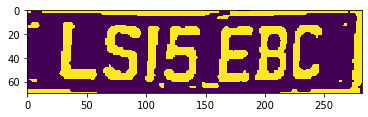

In [21]:
%matplotlib inline 
from matplotlib import pyplot as plt
blnKNNTrainingSuccessful = loadKNNDataAndTrainKNN()         # attempt KNN training

if blnKNNTrainingSuccessful == False:                               # if KNN training was not successful
    print("\nerror: KNN traning was not successful\n")  # show error message                                                          # and exit program
# end if
max=0
ans=""
image1=cv2.imread("BoundedBox/0.jpg")
image2=cv2.imread("BoundedBox/0.jpg")

for idx in range(0,40):
    imgOriginalScene = cv2.imread("photos/frame "+str(idx)+" sec.jpg")
    #imgOriginalScene  = cv2.imread("222.jpg")               # open image

    if imgOriginalScene is None:                            # if image was not read successfully
        print("\nerror: image not read from file \n\n")  # print error message to std out
        os.system("pause")                                  # pause so user can see error message                                              # and exit program
    # end if

    listOfPossiblePlates = detectPlatesInScene(imgOriginalScene)           # detect plates

    listOfPossiblePlates = detectCharsInPlates(listOfPossiblePlates)        # detect chars in plates

    #cv2.imshow("imgOriginalScene", imgOriginalScene)            # show scene image

    if len(listOfPossiblePlates) == 0:                          # if no plates were found
        continue
        #print("\nno license plates were detected\n")  # inform user no plates were found
    else:                                                       # else
                # if we get in here list of possible plates has at leat one plate

                # sort the list of possible plates in DESCENDING order (most number of chars to least number of chars)
        listOfPossiblePlates.sort(key = lambda possiblePlate: len(possiblePlate.strChars), reverse = True)

                # suppose the plate with the most recognized chars (the first plate in sorted by string length descending order) is the actual plate
        licPlate = listOfPossiblePlates[0]
        
        #cv2.imshow("imgPlate", licPlate.imgPlate)           # show crop of plate and threshold of plate
        #cv2.imshow("imgThresh", licPlate.imgThresh)

        if len(licPlate.strChars) == 0:                     # if no chars were found in the plate
            continue
            #print("\nno characters were detected\n\n")  # show message                                          # and exit program
        # end if
        if max < len(licPlate.strChars):
            max=len(licPlate.strChars)
            ans=licPlate.strChars
            image1=licPlate.imgPlate.copy()
            image2=licPlate.imgThresh.copy()
        drawRedRectangleAroundPlate(imgOriginalScene, licPlate)             # draw red rectangle around plate

        #print("\nlicense plate read from image = " + licPlate.strChars + "\n")  # write license plate text to std out
        #print("----------------------------------------")

        writeLicensePlateCharsOnImage(imgOriginalScene, licPlate)           # write license plate text on the image
        
        #cv2.imshow("imgOriginalScene", imgOriginalScene)                # re-show scene image

        cv2.imwrite("imgOriginalScene.png", imgOriginalScene)           # write image out to file

    # end if else

    #cv2.waitKey(0)					# hold windows open until user presses a key
plt.imshow(image1)
cv2.waitKey(0)
cv2.destroyAllWindows();#destroys all the windows we created
plt.imshow(image2)
cv2.waitKey(0)
cv2.destroyAllWindows();#destroys all the windows we created
print ("License plate number is "+ans)
cv2.destroyAllWindows();#destroys all the windows we created